# Walmart Data Analytics

- **The code for training and deploying a walmart data analytics model is contained in this notebook.**
- **The purpose is to estimate a store's weekly sales based on the input data.**

*The information is saved in csv files. There are two csv files: one with the training data (train.csv) and one with the test data (test.csv) (test.csv). All feature names can also be found in a csv file called "features list.csv."*

In [1]:
import pandas as pd
import boto3
import sagemaker

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Dates can be used to organize the information. Combining the features df and sales df dataframes into one.

Using the column date, join a dataframe containing features and sales and then estimate million-dollar weekly revenues.

In [2]:
#pip install sagemaker==1.72.0

In [3]:
# set number of samples that shall be used for visualising test true data and predicted data
NUM_SAMPLES_TEST_VISUALIZATION = 100

Store the standard deviation of weekly sales. This shall then be used to normalize the RMSE value in order to get a better understanding if the RMSE is good or bad. The standard deviation is used in order to also include the outliers.

In [4]:
# Number obtained from the EDA notebook
normalization_factor = int(22711.183519)
print(f"Normalization factor: {normalization_factor}")

Normalization factor: 22711


## Load Data to S3

In [5]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

region = boto3.Session().region_name

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

In [6]:
import os
#training and test data folder
data_dir = "data_converted"

# set prefix, a descriptive name for a directory  
prefix = "Retail_Data_Analytics_Project"
# upload data to S3
train_input = sagemaker_session.upload_data(path=os.path.join(data_dir, "train.csv"), bucket=bucket, key_prefix=prefix)
val_input = sagemaker_session.upload_data(path=os.path.join(data_dir, "val.csv"), bucket=bucket, key_prefix=prefix)
test_input = sagemaker_session.upload_data(path=os.path.join(data_dir, "test.csv"), bucket=bucket, key_prefix=prefix)

In [7]:
# read in test data, assuming it is stored locally
test_data = pd.read_csv(os.path.join(data_dir, "test_with_true_label.csv"), header=None, names=None)

# labels are in the first column
test_y_true = test_data.iloc[:,0]
test_x = test_data.iloc[:,1:]

### Checking if data upload to S3 was successful.

In [8]:
empty_check = []
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    print(obj.key)

assert len(empty_check) !=0, 'S3 bucket is empty.'
print('Test passed!')

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


Retail_Data_Analytics_Project/test.csv
Retail_Data_Analytics_Project/train.csv
Retail_Data_Analytics_Project/val.csv
Test passed!


## Train the Linear Regression Model

<br>
The model is trained using the sklearn library. The training code is located in the file "train_linear_regression.py" within the source folder.

In [9]:
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"
script_path = 'source/train_linear_regression.py'

sklearn_linear_regression = SKLearn(
    entry_point=script_path,
    framework_version=FRAMEWORK_VERSION,
    instance_type="ml.m4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session)

### Train

In [10]:
%%time

# Train the estimator on S3 training data
sklearn_linear_regression.fit({"train": train_input, "validation": val_input})

2022-05-05 23:22:24 Starting - Starting the training job...
2022-05-05 23:22:54 Starting - Preparing the instances for trainingProfilerReport-1651792944: InProgress
............
2022-05-05 23:24:52 Downloading - Downloading input data...
2022-05-05 23:25:21 Training - Downloading the training image......
2022-05-05 23:26:21 Training - Training image download completed. Training in progress..2022-05-05 23:26:24,869 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2022-05-05 23:26:24,872 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-05-05 23:26:24,884 sagemaker_sklearn_container.training INFO     Invoking user training script.
2022-05-05 23:26:25,426 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-05-05 23:26:25,450 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-05-05 23:26:25,471 sagemaker-training-toolkit INFO     No GPUs detect

### Deploy

In [11]:
%%time

# deploy the model
predictor_linear_regression = sklearn_linear_regression.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

-----------!CPU times: user 184 ms, sys: 4.82 ms, total: 189 ms
Wall time: 5min 32s


### Evaluate

In [12]:
# MSE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

test_y_preds = predictor_linear_regression.predict(test_x.values)
rmse_linear_regression = mean_squared_error(test_y_true, test_y_preds, squared=False)
r2_linear_regression = r2_score(test_y_true, test_y_preds)
print(f"Normalized RMSE: {rmse_linear_regression/normalization_factor}")
print(f"R-Squared Score: {r2_linear_regression}")

Normalized RMSE: 0.945346774424288
R-Squared Score: 0.09123065397155095


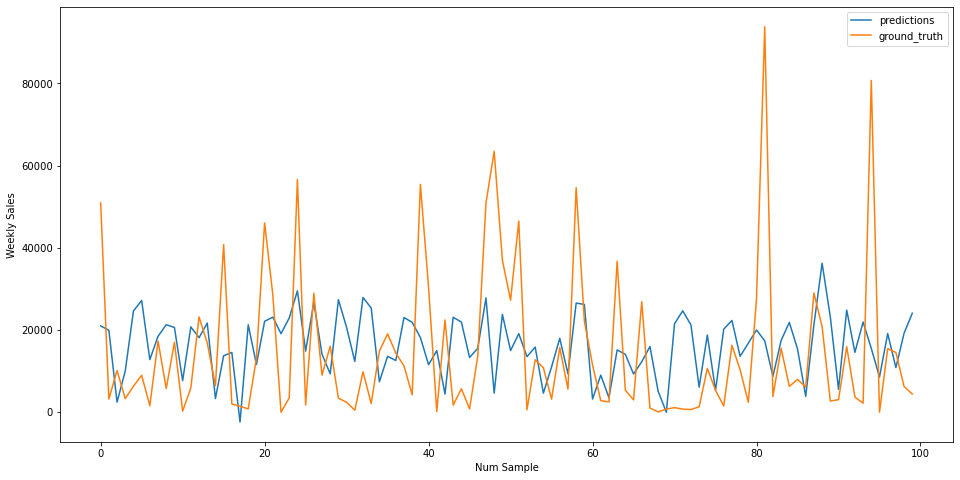

In [13]:
# plot results
num_samples_test = 100
fig = plt.figure(figsize=(16, 8))
plt.plot(test_y_preds[:NUM_SAMPLES_TEST_VISUALIZATION])
plt.plot(test_y_true[:NUM_SAMPLES_TEST_VISUALIZATION])
plt.legend(("predictions", "ground_truth"))
plt.ylabel("Weekly Sales")
plt.xlabel("Num Sample")
plt.show()

## Train XGBoost Regressor with Hyperparameter Tuning

the hyperparameter tuner and the xgboost regressor from sagemaker will be used. The hyperarameter tuner is using bayes optimization and the best performing estimator will be deployed.

In [14]:
container = sagemaker.image_uris.retrieve('xgboost', region=region, version="1.0-1")

prefix = "Retail_Data_Analytics_Project"

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sagemaker_session)

In [15]:
# Sagemaker imports for Hyperparameter Tuner
from sagemaker.tuner import IntegerParameter
from sagemaker.tuner import ContinuousParameter
from sagemaker.tuner import HyperparameterTuner

# default values as per Amazon SageMaker Documentation)
hyperparameter_ranges = {
    'alpha': ContinuousParameter(0, 1000, scaling_type="Auto"),
    'eta': ContinuousParameter(0.1, 0.5, scaling_type='Logarithmic'),
    'gamma':ContinuousParameter(0, 5, scaling_type='Auto'),
    'lambda': ContinuousParameter(0,100,scaling_type='Auto'),
    'max_delta_step': IntegerParameter(0,10,scaling_type='Auto'),
    'max_depth': IntegerParameter(0,10,scaling_type='Auto'),
    'min_child_weight': ContinuousParameter(0,10,scaling_type='Auto'),
    'subsample': ContinuousParameter(0.5,1,scaling_type='Logarithmic'),
    'num_round': IntegerParameter(50,1000,scaling_type='Auto')
}


In [16]:
tuner_log = HyperparameterTuner(xgb,
                                objective_metric_name="validation:rmse",
                                objective_type='Minimize',
                                hyperparameter_ranges=hyperparameter_ranges,
                                max_jobs=20,
                                max_parallel_jobs=4,
                                strategy='Bayesian')

### Train

In [17]:
from sagemaker.inputs import TrainingInput

train_channel = TrainingInput(train_input, content_type='text/csv')
valid_channel = TrainingInput(val_input, content_type='text/csv')

data_channels = {'train': train_channel, 'validation': valid_channel}

In [18]:
%%time
# Starts the hyperparameter tuning job
tuner_log.fit(inputs=data_channels,  logs=True)

.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!
CPU times: user 2.77 s, sys: 211 ms, total: 2.98 s
Wall time: 49min 41s


### Deploy

In [19]:
# Fetch the best trained(tuned) version

xgb_attached = sagemaker.estimator.Estimator.attach(tuner_log.best_training_job())


2022-05-06 00:20:50 Starting - Preparing the instances for training
2022-05-06 00:20:50 Downloading - Downloading input data
2022-05-06 00:20:50 Training - Training image download completed. Training in progress.
2022-05-06 00:20:50 Uploading - Uploading generated training model
2022-05-06 00:20:50 Completed - Training job completed


In [20]:
xgb_transformer = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [21]:
xgb_transformer.transform(test_input, content_type='text/csv', split_type='Line')

.....................................[2022-05-06:00:28:23:INFO] No GPUs detected (normal if no gpus installed)
[2022-05-06:00:28:23:INFO] No GPUs detected (normal if no gpus installed)
[2022-05-06:00:28:23:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2022-05-06 00:28:23 +0000] [18] [INFO] Startin

### Evaluate

In [22]:
# copy predictions file from s3 
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-008030599527/sagemaker-xgboost-2022-05-06-00-22-24-594/test.csv.out to data_converted/test.csv.out


In [23]:
# MSE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

test_y_preds = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
rmse_xgboost = mean_squared_error(test_y_true, test_y_preds, squared=False)
r2_xgboost = r2_score(test_y_true, test_y_preds)
print(f"Normalized RMSE: {rmse_xgboost/normalization_factor}")
print(f"R-Squared Score: {r2_xgboost}")

Normalized RMSE: 0.18885143509305066
R-Squared Score: 0.963732973077168


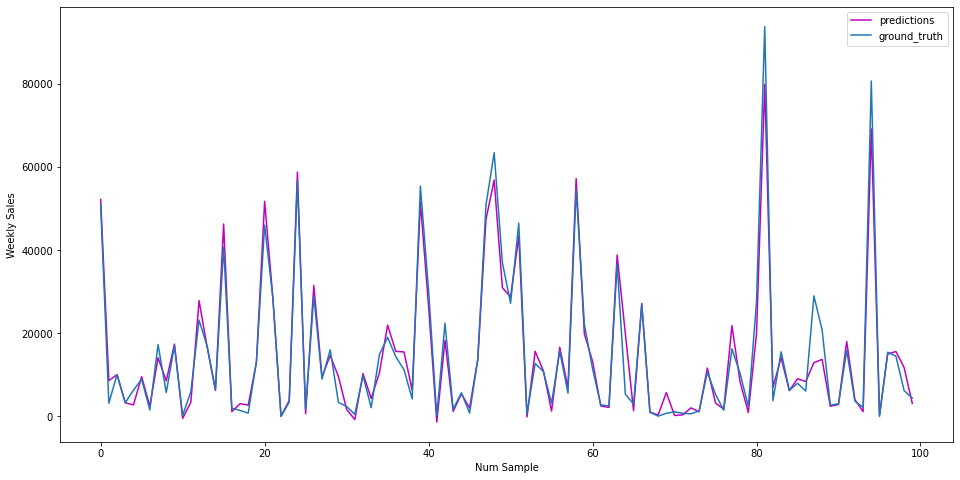

In [24]:

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 8))
plt.plot(test_y_preds[:NUM_SAMPLES_TEST_VISUALIZATION], color = 'm')
plt.plot(test_y_true[:NUM_SAMPLES_TEST_VISUALIZATION])
plt.legend(("predictions", "ground_truth"))
plt.ylabel("Weekly Sales")
plt.xlabel("Num Sample")
plt.show()